In [28]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple,deque
from itertools import count
from PIL import Image

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [62]:
if gym.__version__ <'0.26':
    env = gym.make('CartPole-v0', new_step_api = True, render_mode = 'single_rgb_array')
else:
    env = gym.make('CartPole-v0',render_mode = 'rgb_array').unwrapped

    is_ipython = 'inline' in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    

/opt/conda/envs/d2l-zh/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [63]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class ReplayMemory(object):
    def __init__(self,capacity):
        self.memory = deque([], maxlen = capacity)
    
    def push(self,*args):
        self.memory.append(Transition(*args))
    
    def sample(self,batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory) 
        

In [64]:
class DQN(nn.Module):
    def __init__(self,h,w,outputs):
        super(DQN,self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,32,kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size-(kernel_size -1) -1 )//stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self,x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0),-1))
    
        
                   
        

/tmp/ipykernel_729/1371693657.py:2: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(40,interpolation = Image.CUBIC),
/opt/conda/envs/d2l-zh/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

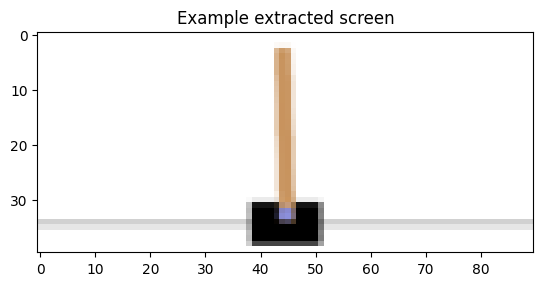

In [65]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40,interpolation = Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold*2
    scale = screen_width / world_width 
    return int(env.state[0]*scale + screen_width / 2.0)

def get_screen():
    screen = env.render().transpose((2,0,1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    view_width = int(screen_width*0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width //2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width//2):
        slice_range = slice(-view_width,None)
    else:
        slice_range = slice(cart_location - view_width//2, cart_location + view_width//2)
    
    screen = screen[:,:,slice_range]
    
    screen = np.ascontiguousarray(screen, dtype = np.float32)/255
    screen = torch.from_numpy(screen)
    
    return resize(screen).unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [66]:
BATCH_SIZE=128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions =env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer =optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done =0 

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END)*math.exp(-1*steps_done/EPS_DECAY)
    if sample >eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device = device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype = torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t)>=100:
        means = durations_t.unfold(0,100,1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99),means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        


In [67]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s:s is not None, batch.next_state)), device = device, dtype = torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1,action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()

In [68]:
num_episodes = 50
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_action(state)
        _,reward,done,_,_ = env.step(action.item())
        reward = torch.tensor([reward], device = device)
        
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
    
    if i_episode%TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 640x480 with 0 Axes>

Complete


<Figure size 640x480 with 0 Axes>